# SSD

## Setup
Import libraries

In [1]:
import cv2
import torch, torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.detection.ssd import SSDClassificationHead
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import time

## Pre-Training

Load SSD model with pretrained VGG16 backbone

In [2]:
ssd = torchvision.models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.DEFAULT)
ssd

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Change the final classification layer to predict the # of categories we are looking for (with same input dims and anchors nums). No need to alter the bounding box regression head

In [3]:
ssd.head.classification_head = SSDClassificationHead([512, 1024, 512, 256, 256, 256], [4, 6, 6, 6, 4, 4], 4)
ssd

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Load 300 images from the dataset. Looks like the most common box category is cyclists, followed by pedestrians

In [30]:
i = 0
num = 300
images = []
targets = []

labels_list = ['__background__','pedestrian', 'cyclist', 'motorcyclist', 'tricyclist', 'wheelchairuser', 'mopedrider']
cyclist_cnt, ped_cnt, other_cnt = 0, 0, 0

directory = list(os.walk('../dataset/labels'))
for f in directory[0][2]:
    if i >= num:
        break
    i += 1

    with open('../dataset/labels/' + f) as file:
        jsonfile = json.load(file)

        image = cv2.imread('../dataset/images/' +jsonfile['imagename'])
        transform = transforms.Compose([transforms.ToTensor()])
        images.append(transform(image))

        dict = {}
        boxes, labels = [], []
        for bbox in jsonfile['children']:
            if bbox['identity'] == 'cyclist':
                cyclist_cnt += 1
            elif bbox['identity'] == 'pedestrian':
                ped_cnt += 1
            else:
                other_cnt += 1
            label = labels_list.index(bbox['identity'])
            if label >= 3:
                label = 3
            labels.append(label)
            boxes.append([bbox['mincol'], bbox['minrow'], bbox['maxcol'], bbox['maxrow']])
        targets.append({'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)})
print('cyclists: {}, pedestrians: {}, other: {}'.format(cyclist_cnt, ped_cnt, other_cnt))
print(targets)

cyclists: 502, pedestrians: 164, other: 20
[{'boxes': tensor([[1034,  409, 1056,  470],
        [1767,  317, 1930,  822],
        [1673,  360, 1816,  654],
        [1266,  410, 1289,  478],
        [1173,  403, 1191,  478],
        [1058,  411, 1085,  476]]), 'labels': tensor([2, 1, 1, 1, 1, 1])}, {'boxes': tensor([[1024,  400, 1047,  463],
        [1817,  324, 1972,  711],
        [1263,  402, 1284,  473],
        [1158,  393, 1188,  472],
        [1044,  402, 1069,  472]]), 'labels': tensor([2, 1, 1, 1, 1])}, {'boxes': tensor([[1007,  400, 1032,  466],
        [1028,  403, 1053,  465],
        [1253,  401, 1275,  476],
        [1144,  392, 1176,  478],
        [1022,  402, 1049,  475]]), 'labels': tensor([2, 2, 1, 1, 1])}, {'boxes': tensor([[ 981,  399, 1008,  468],
        [1001,  402, 1027,  467],
        [1221,  401, 1257,  481],
        [1118,  390, 1141,  479],
        [ 989,  401, 1017,  483]]), 'labels': tensor([2, 2, 1, 1, 1])}, {'boxes': tensor([[ 948,  411,  976,  484],
   

## Training

Fine tune our pretrained model on 300 images (with batch size of 20) for 10 epochs. Also save model parameters 

In [5]:
optimizer = torch.optim.SGD(ssd.parameters(), lr=0.0001, momentum=0.9)

In [6]:
loss_list = []
best_loss = 1000
file = os.path.join(os.getcwd(), 'ssd.pt')
start = time.time()
for epoch in range(10):
    ssd.train()
    loss_sublist = []
    for i in range(15):
        # print(i)
        cur = i*20
        X = images[cur:cur+20]
        y = targets[cur:cur+20]
        
        j = 0
        while j < len(y):
            if len(y[j]['boxes'].detach().numpy()) == 0:
                X.pop(j)
                y.pop(j)
                j -= 1
            j += 1
        if len(y) == 0:
            continue

        loss = ssd(X, y)
        print(loss)
        losses = sum(l for l in loss.values())
        print(str(loss['bbox_regression'].item()), str(loss['classification'].item()))
        loss_sublist.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    if np.mean(loss_sublist) < best_loss:
        torch.save(ssd.state_dict(), file)
        best_loss = np.mean(loss_sublist)
        print('current model saved')
    
    print('epoch '+str(epoch)+' combined loss: '+str(loss_list[-1]))
end = time.time()
print('time', end-start)

{'bbox_regression': tensor(1.7546, grad_fn=<DivBackward0>), 'classification': tensor(16.3597, grad_fn=<DivBackward0>)}
1.7546128034591675 16.359731674194336
{'bbox_regression': tensor(2.5137, grad_fn=<DivBackward0>), 'classification': tensor(13.9315, grad_fn=<DivBackward0>)}
2.5137417316436768 13.93146800994873
{'bbox_regression': tensor(2.4259, grad_fn=<DivBackward0>), 'classification': tensor(12.0371, grad_fn=<DivBackward0>)}
2.4258642196655273 12.03707218170166
{'bbox_regression': tensor(1.3071, grad_fn=<DivBackward0>), 'classification': tensor(10.6331, grad_fn=<DivBackward0>)}
1.3070921897888184 10.633125305175781
{'bbox_regression': tensor(5.1313, grad_fn=<DivBackward0>), 'classification': tensor(9.6497, grad_fn=<DivBackward0>)}
5.131282806396484 9.649702072143555
{'bbox_regression': tensor(3.3409, grad_fn=<DivBackward0>), 'classification': tensor(8.6232, grad_fn=<DivBackward0>)}
3.3408775329589844 8.623205184936523
{'bbox_regression': tensor(2.8852, grad_fn=<DivBackward0>), 'clas

## Evaluation

Let's visualize how our model performs on the same dataset as Faster R-CNN. Note that all of these images were used during training (since we selected 300 images instead of 100), but we can still see that the results are poor. Here, I've tweaked the code below to save 30 images each to folders images1/, images2/ and images3/

In [29]:
new_labels_list = ['__background__','pedestrian', 'cyclist', 'other']

ssd.eval()
for i in range(30):
    X = images[i+210] # 0, 135, 210
    X_vis = (X.detach().numpy().transpose(1, 2, 0)*255).astype(np.int32).copy()
    z = ssd([X])
    boxes, labels, scores = z[0]['boxes'], z[0]['labels'], z[0]['scores']
    print(scores)
    for box, label, score in zip(boxes.detach().numpy(), labels.detach().numpy(), scores.detach().numpy()):
        if score < 0.35: 
            continue
        #print(box, label)
        color = (255, 255, 255)
        if labels_list[label] == 'cyclist':
            color = (0, 255, 0)
        elif labels_list[label] == 'pedestrian':
            color = (0, 0, 255)
        bbox = [int(pt) for pt in box]
        cv2.rectangle(X_vis, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness=2)
        cv2.putText(X_vis, new_labels_list[label], (bbox[0], bbox[1]), color=color, fontFace=0, fontScale=1)
    cv2.imwrite('images3/'+str(i)+'.png', X_vis)
    plt.show()

tensor([0.3790, 0.3773, 0.3656, 0.3583, 0.3524, 0.3509, 0.3499, 0.3495, 0.3476,
        0.3474, 0.3467, 0.3467, 0.3465, 0.3463, 0.3407, 0.3393, 0.3375, 0.3375,
        0.3354, 0.3321, 0.3317, 0.3313, 0.3313, 0.3301, 0.3297, 0.3295, 0.3293,
        0.3279, 0.3273, 0.3273, 0.3266, 0.3262, 0.3260, 0.3257, 0.3248, 0.3246,
        0.3240, 0.3236, 0.3235, 0.3232, 0.3225, 0.3223, 0.3220, 0.3216, 0.3211,
        0.3209, 0.3202, 0.3197, 0.3197, 0.3191, 0.3184, 0.3177, 0.3175, 0.3174,
        0.3169, 0.3169, 0.3160, 0.3153, 0.3151, 0.3145, 0.3144, 0.3140, 0.3137,
        0.3136, 0.3135, 0.3134, 0.3128, 0.3125, 0.3123, 0.3122, 0.3119, 0.3119,
        0.3118, 0.3116, 0.3108, 0.3104, 0.3102, 0.3100, 0.3096, 0.3089, 0.3085,
        0.3084, 0.3084, 0.3082, 0.3080, 0.3078, 0.3077, 0.3074, 0.3074, 0.3073,
        0.3071, 0.3070, 0.3064, 0.3064, 0.3063, 0.3054, 0.3052, 0.3052, 0.3048,
        0.3048, 0.3048, 0.3045, 0.3044, 0.3042, 0.3041, 0.3040, 0.3039, 0.3034,
        0.3031, 0.3026, 0.3026, 0.3025, 

Let's also plot the training curve

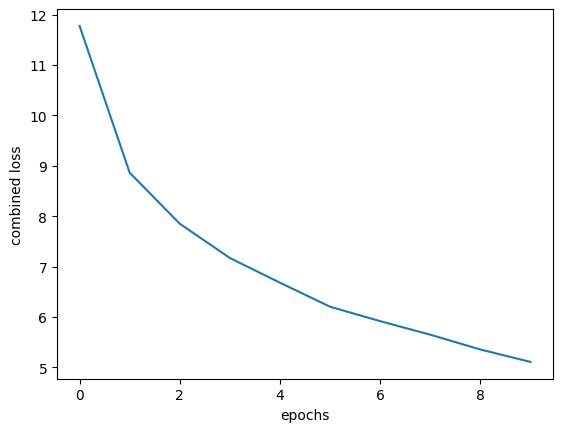

In [13]:
fig, ax = plt.subplots()

ax.plot(list(range(10)), loss_list)
ax.set_ylabel('combined loss')
ax.set_xlabel('epochs')

plt.show()